In [15]:

# # import requests
# # from secret import WEATHER_KEY
# from datetime import datetime, timedelta
# from gym import Env, spaces
# from data_process import get_all_rooms
# from util import get_cop, get_temp, valve_effectiveness, valve_multiplier
# bms_data = get_all_rooms("data-bms")

# # import os
# # print(os.listdir())



# class RoomsEnv(Env):
#     def __init__(self, target_datetime, target_temp, bms_data, temp_inside=17, hours_to_heat=6, place_id="lviv"):
#         self.target_datetime = datetime.strptime(target_datetime, '%Y-%m-%d %H:%M:%S')
#         self.start_heating_time = self.target_datetime - timedelta(hours=hours_to_heat)
#         self.current_time = self.start_heating_time
#         self.target_temp = target_temp
#         self.action_space = spaces.Discrete(3)
#         self.actions = [17, 18, 20]
#         self.bms_data = bms_data
#         self.hours_to_heat = hours_to_heat
#         self.start_temp_inside = temp_inside
#         self.current_temp_inside = temp_inside

#         self.observation_space = spaces.Dict(
#             {
#                 "agent": spaces.Discrete(hours_to_heat),
#                 "target": hours_to_heat,
#             }
#         )
#         # payload = {"place_id": place_id, "sections": "current,hourly", "key": WEATHER_KEY}
#         # response = requests.get("https://www.meteosource.com/api/v1/free/point?", params=payload)
#         # self.weather_forecast = 
#         if self.target_datetime < datetime.now():
            
#             try:
#                 self.temp_for_day = get_temp(self.target_datetime.date())
#                 if self.start_heating_time.day != self.target_datetime.day:
#                     self.temp_for_day.update(get_temp(self.start_heating_time.date()))
#             except KeyError:
#                 raise(NoTemperatureForThisDateFoundError("Could not find a temperature for this date in the API archive. Please try another date."))
        
#         self.current_temp_outside = self.temp_for_day[self.current_time.strftime("%Y-%m-%d %H:%M:%S")]

#     def _get_obs(self):
#         return {"agent": self._agent_location, "target": self._target_location}
    
#     def reset(self):
#         self._agent_location = 0
#         self.current_temp_inside = self.start_temp_inside
#         self.current_temp_outside = self.temp_for_day[self.current_time]


#     def step(self, valve):
#         observation = self._get_obs()
#         curr_time = self.start_heating_time + timedelta(hours=observation["agent"])
#         curr_time_str = curr_time.strftime("%Y-%m-%d %H:%M:%S")
#         self.current_temp_outside = self.temp_for_day[curr_time_str]

#         temp_change = valve_effectiveness(self.bms_data, valve=valve, temp=self.current_temp_inside)
#         self.current_temp_inside += temp_change
#         cop = get_cop(self.current_temp_outside)
#         reward = cop * valve_multiplier[valve]
        
#         if observation["agent"] + 1 == observation["target"]:
#             penalty_temp = abs(self.target_temp - self.current_temp_inside)
#             reward /= (1 - penalty_temp)
#             terminated = True
#         else:
#             terminated = False
        
#         observation = self._get_obs()

#         return (tuple(observation), reward, terminated, None)
 

# re = RoomsEnv("2022-12-25 03:00:00", 23.1, bms_data)
# print(re.step(("2022-12-25 04:00:00", 20)))
# print(re.step(("2022-12-25 05:00:00", 20)))

In [16]:
import numpy as np
from datetime import datetime, timedelta
from gym import Env, spaces
from data_process import get_all_rooms
from util import get_cop, get_temp, valve_effectiveness, valve_multiplier
from valve_estimation import valve_line
bms_data = get_all_rooms("data-bms")
valve_dict = {0: 17, 1: 18, 2: 20}
import matplotlib.pyplot as plt

class NoTemperatureForThisDateFoundError:
    pass

class RoomsEnv(Env):
    def __init__(self, target_datetime, target_temp, bms_data, temp_inside=18, hours_to_heat=6, place_id="lviv", valve_positions=[17, 18, 20]):
        self.valve_positions = valve_positions
        self.action_space = spaces.Discrete(len(valve_positions))
        # self.reward_range = (0, 7)
        self.hours_to_heat = hours_to_heat
        self.target_datetime = datetime.strptime(target_datetime, '%Y-%m-%d %H:%M:%S')
        self.start_heating_time = self.target_datetime - timedelta(hours=hours_to_heat)
        self.temp_change = 0
        if self.target_datetime < datetime.now():
            
            try:
                self.temp_for_day = get_temp(self.target_datetime.date())
                if self.start_heating_time.day != self.target_datetime.day:
                    self.temp_for_day.update(get_temp(self.start_heating_time.date()))
            except KeyError:
                raise(NoTemperatureForThisDateFoundError("Could not find a temperature for this date in the API archive. Please try another date."))
        self.start_temp_inside = temp_inside

        self.current_temp_outside = self.temp_for_day[self.start_heating_time.strftime("%Y-%m-%d %H:%M:%S")]

        # defining initial state

        self.state = np.array([self.start_temp_inside, 0, self.current_temp_outside])

        self.target_temp = target_temp

        # dataframe

        self.bms_data = bms_data

        self.time_step = 1


    def reset(self):
        self.current_temp_outside = self.temp_for_day[self.start_heating_time.strftime("%Y-%m-%d %H:%M:%S")]
        self.state = np.array([self.start_temp_inside, 0, self.current_temp_outside])
        return tuple(self.state), {}

    def step(self, action):
        valve = valve_dict[action]
        self.temp_change = valve_line(self.bms_data)[valve](self.state[0])
        # print(valve, self.state[0], temp_change)
        cop = get_cop(self.state[2])
        self.state[1] += 1
        curr_time = self.start_heating_time + timedelta(hours=self.state[1])
        self.state[2] = self.temp_for_day[curr_time.strftime("%Y-%m-%d %H:%M:%S")]

        # print(temp_change, self.state[2], valve, self.state[0])
        self.state[0] += self.temp_change

        temp_deviation = abs(self.state[0] - self.target_temp)
        if temp_deviation > 0.5:
            comfort = -1
        else:
            comfort = 1

        reward = cop * valve_multiplier[valve] * comfort - temp_deviation
        
        terminated = False
        if self.state[1] == self.hours_to_heat - 1:
            terminated = True
            


        return (tuple(self.state), reward, terminated, False, {})

In [17]:
env = RoomsEnv("2022-12-25 08:00:00", 22, bms_data)

In [18]:
from collections import defaultdict

class TempAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [19]:
learning_rate = 0.01
n_episodes = 1000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = TempAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [20]:
import gym
from tqdm import tqdm
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()


100%|██████████| 1000/1000 [00:06<00:00, 161.17it/s]


In [21]:
# import torch
# import torch.nn as nn
# import numpy as np

# class DQN(nn.Module):
#     def __init__(self, input_shape, n_actions):
#         super(DQN, self).__init__()
#         self.conv = nn.Sequential(
#         nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
#         nn.ReLU(),
#         nn.Conv2d(32, 64, kernel_size=4, stride=2),
#         nn.ReLU(),
#         nn.Conv2d(64, 64, kernel_size=3, stride=1),
#         nn.ReLU()
#     )
#         conv_out_size = self._get_conv_out(input_shape)
#         self.fc = nn.Sequential(
#                 nn.Linear(conv_out_size, 512),
#                 nn.ReLU(),
#                 nn.Linear(512, n_actions)
#             )
#     def _get_conv_out(self, shape):
#          o = self.conv(torch.zeros(1, *shape))
#          return int(np.prod(o.size()))
#     def forward(self, x):
#          conv_out = self.conv(x).view(x.size()[0], -1)
#          return self.fc(conv_out)

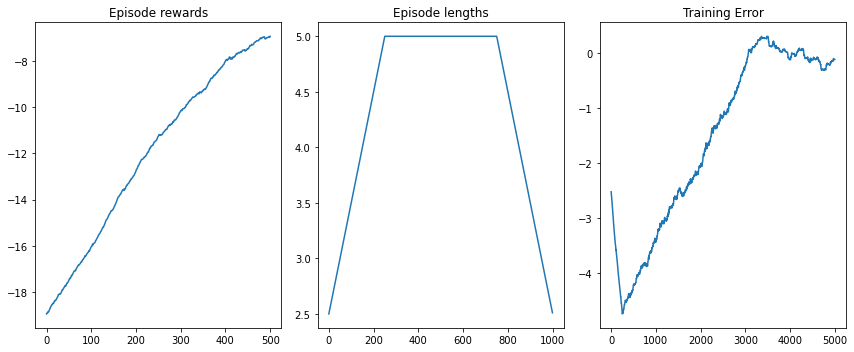

In [22]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

In [23]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
obs, info = env.reset()
for i in range(6):
    action = agent.get_action(obs)
    print(env.temp_change)

    obs, reward, terminated, _, _ = env.step(action)
    print(action, obs, reward)


-0.16515988238679058
2 (19.28, 1.0, 2.6) -4.574189999999999
1.28
2 (20.4448, 2.0, 2.6) -3.4093899999999993
1.1647999999999998
2 (21.504768000000002, 3.0, 2.9) 1.358958000000002
1.059968
2 (22.469338880000002, 4.0, 3.3) 1.4160661199999978
0.9645708799999997
1 (22.30417899761321, 5.0, 4.3) 2.3960080023867896
-0.16515988238679058
0 (22.12775654782568, 6.0, 4.4) 3.55388245217432


In [24]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
observation, info = env.reset()
done = False
while not done:
  # env.render()
  action = agent.get_action(observation) # your agent 
  observation, reward, done, info, _ = env.step(action)
  print(env.temp_change)
  print(action, observation, reward)
env.close()


1.28
2 (19.28, 1.0, 2.6) -4.574189999999999
1.1647999999999998
2 (20.4448, 2.0, 2.6) -3.4093899999999993
1.059968
2 (21.504768000000002, 3.0, 2.9) 1.358958000000002
0.9645708799999997
2 (22.469338880000002, 4.0, 3.3) 1.4160661199999978
-0.16515988238679058
1 (22.30417899761321, 5.0, 4.3) 2.3960080023867896


In [25]:
# import seaborn as sns
# from matplotlib.patches import Patch


# def create_grids(agent, usable_ace=False):
#     """Create value and policy grid given an agent."""
#     # convert our state-action values to state values
#     # and build a policy dictionary that maps observations to actions
#     state_value = defaultdict(float)
#     policy = defaultdict(int)
#     for obs, action_values in agent.q_values.items():
#         state_value[obs] = float(np.max(action_values))
#         policy[obs] = int(np.argmax(action_values))

#     player_count, dealer_count = np.meshgrid(
#         # players count, dealers face-up card
#         np.arange(12, 22),
#         np.arange(1, 11),
#     )

#     # create the value grid for plotting
#     value = np.apply_along_axis(
#         lambda obs: state_value[(obs[0], obs[1], usable_ace)],
#         axis=2,
#         arr=np.dstack([player_count, dealer_count]),
#     )
#     value_grid = player_count, dealer_count, value

#     # create the policy grid for plotting
#     policy_grid = np.apply_along_axis(
#         lambda obs: policy[(obs[0], obs[1], usable_ace)],
#         axis=2,
#         arr=np.dstack([player_count, dealer_count]),
#     )
#     return value_grid, policy_grid


# def create_plots(value_grid, policy_grid, title: str):
#     """Creates a plot using a value and policy grid."""
#     # create a new figure with 2 subplots (left: state values, right: policy)
#     player_count, dealer_count, value = value_grid
#     fig = plt.figure(figsize=plt.figaspect(0.4))
#     fig.suptitle(title, fontsize=16)

#     # plot the state values
#     ax1 = fig.add_subplot(1, 2, 1, projection="3d")
#     ax1.plot_surface(
#         player_count,
#         dealer_count,
#         value,
#         rstride=1,
#         cstride=1,
#         cmap="viridis",
#         edgecolor="none",
#     )
#     plt.xticks(range(12, 22), range(12, 22))
#     plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
#     ax1.set_title(f"State values: {title}")
#     ax1.set_xlabel("Player sum")
#     ax1.set_ylabel("Dealer showing")
#     ax1.zaxis.set_rotate_label(False)
#     ax1.set_zlabel("Value", fontsize=14, rotation=90)
#     ax1.view_init(20, 220)

#     # plot the policy
#     fig.add_subplot(1, 2, 2)
#     ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
#     ax2.set_title(f"Policy: {title}")
#     ax2.set_xlabel("Player sum")
#     ax2.set_ylabel("Dealer showing")
#     ax2.set_xticklabels(range(12, 22))
#     ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

#     # add a legend
#     legend_elements = [
#         Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
#         Patch(facecolor="grey", edgecolor="black", label="Stick"),
#     ]
#     ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
#     return fig


# # state values & policy with usable ace (ace counts as 11)
# value_grid, policy_grid = create_grids(agent, usable_ace=True)
# fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
# plt.show()